In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from os.path import abspath
from darts import TimeSeries
from darts.utils.missing_values import extract_subseries, fill_missing_values

In [2]:
path_to_inflow = "../observations/wwtp.csv"
path_to_dmi_data = "../observations/dmi.csv"

inflow = pd.read_csv(abspath(path_to_inflow), parse_dates=True, index_col=0, sep=";")
inflow.index.name = "time"
inflow.index = inflow.index.tz_localize(
    "Europe/Copenhagen", ambiguous="NaT"
).tz_convert("utc")

climate = pd.read_csv(abspath(path_to_dmi_data), parse_dates=True, index_col=0, sep=",")
data = inflow.merge(climate, left_index=True, right_index=True, how="inner")

data.interpolate(inplace=True)
data.head()

,FB20F11_81,acc_precip,mean_pressure,mean_radiation,mean_relative_hum,mean_temp,temp_grass,temp_soil_10,temp_soil_30
time,,,,,,,,,
2023-09-21 10:00:00+00:00,974.452333,0.0,998.4,535.0,68.5,20.8,20.5,15.0,14.6
2023-11-01 05:00:00+00:00,1701.950500,0.0,1005.4,0.0,98.0,-3.4,-3.6,8.2,9.7
2023-11-07 08:00:00+00:00,1338.937500,0.0,1000.8,53.0,98.3,4.0,1.3,8.5,9.5
2023-11-07 09:00:00+00:00,2243.327667,0.0,1001.1,162.0,98.5,7.6,5.6,8.5,9.4
2023-11-07 10:00:00+00:00,1988.214167,0.0,1001.7,166.0,95.5,8.6,9.5,8.4,9.4


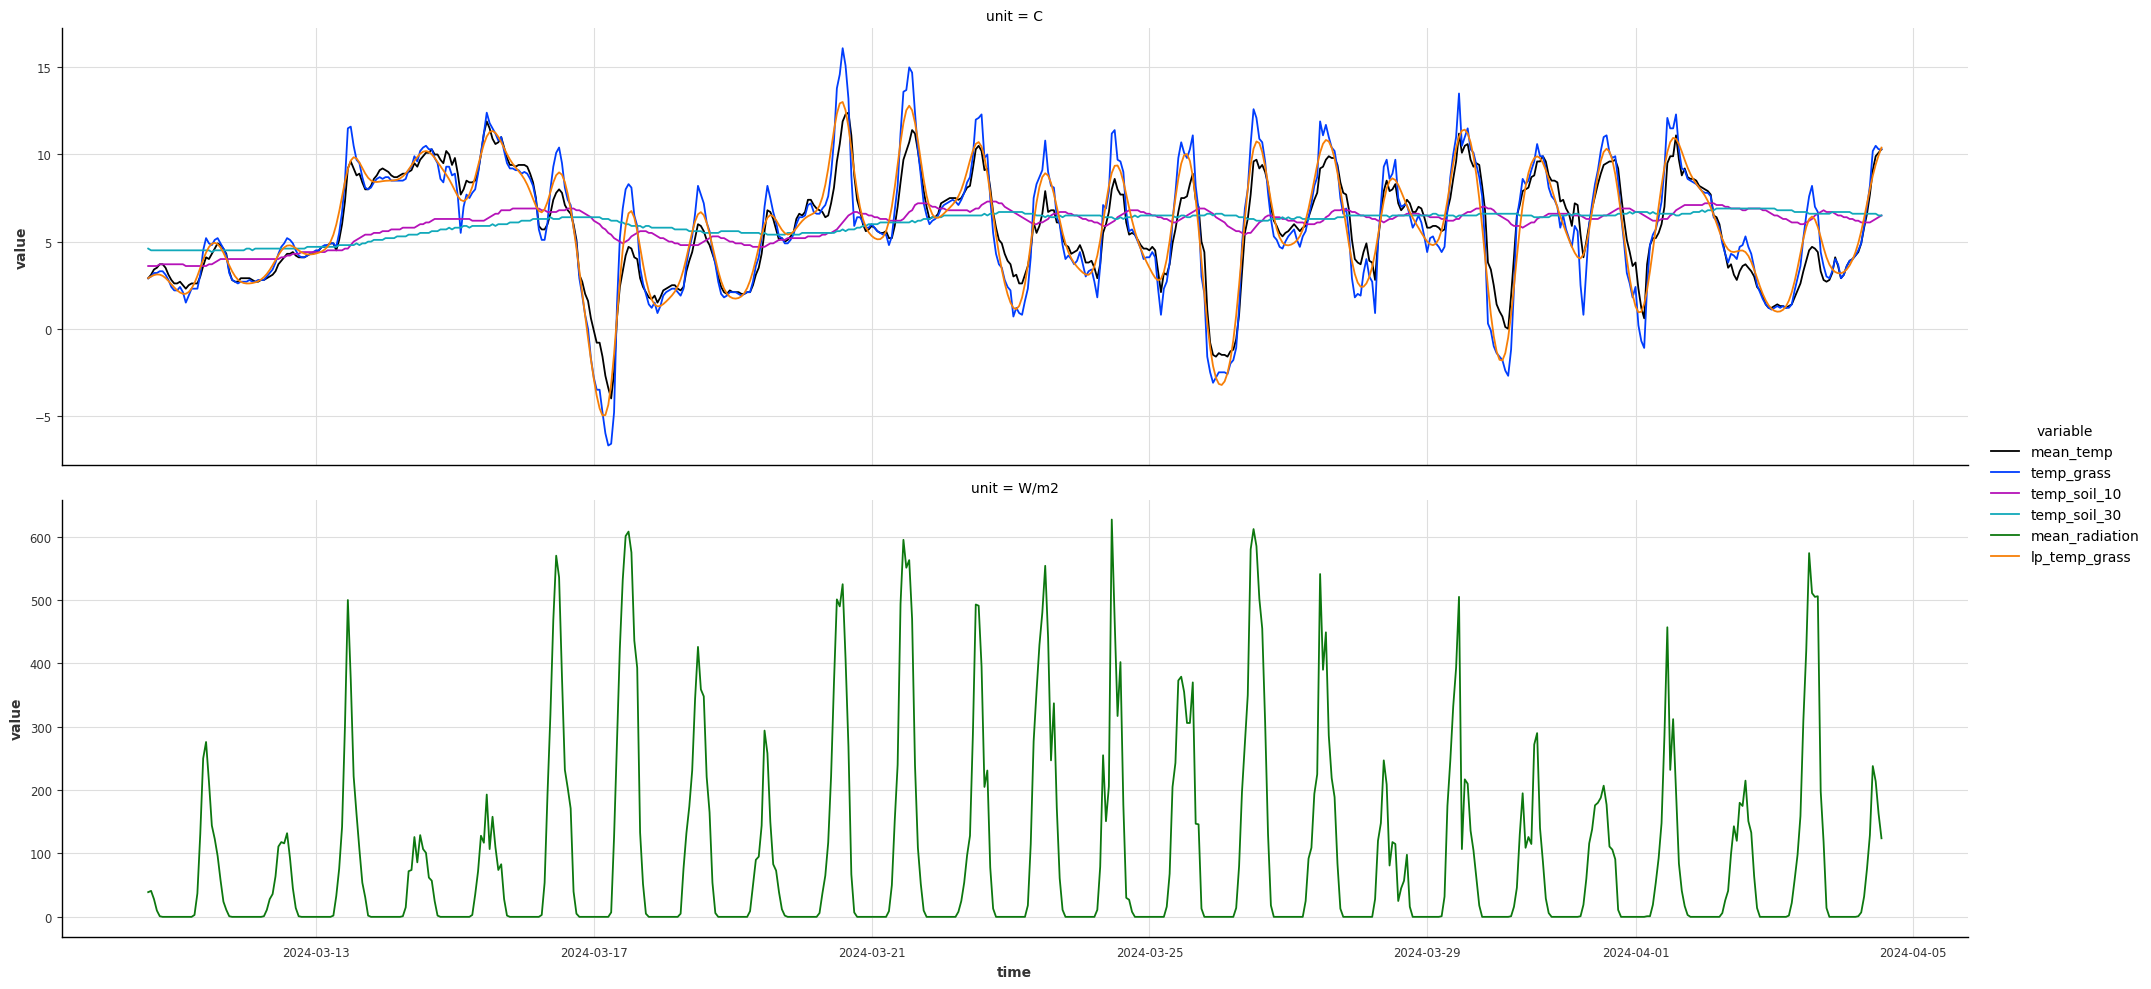

In [ ]:
with open("./units.json", "r") as f:
    units = json.load(f)


datplot = data[
    ["mean_temp", "temp_grass", "temp_soil_10", "temp_soil_30", "mean_radiation"]
].iloc[1800:2400, :]

dfmelt = datplot.melt(ignore_index=False)
dfmelt["unit"] = dfmelt["variable"].map(units)

sns.relplot(
    dfmelt.reset_index(),
    x="time",
    y="value",
    row="unit",
    kind="line",
    hue="variable",
    facet_kws=dict(sharey=False),
    aspect=4,
)

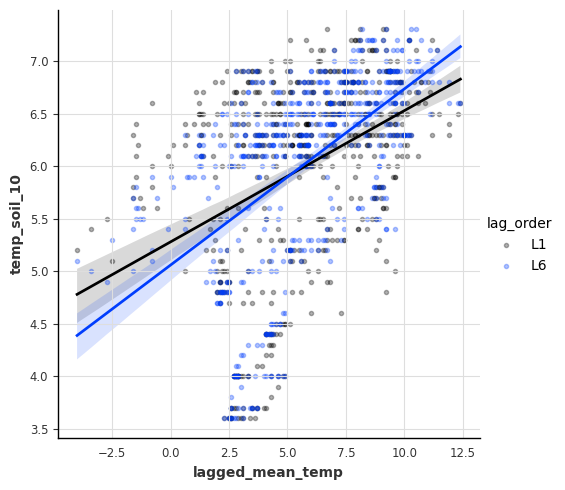

In [91]:
lags = [1, 6]
variable1 = "temp_soil_10"
variable2 = "mean_temp"

if variable2 is None:
    variable2 = variable1

list_of_dfs = []
for lag in lags:
    list_of_dfs.append(
        pd.DataFrame(
            {
                variable1: datplot[variable1].values,
                f"lagged_{variable2}": datplot[variable2].shift(lag).values,
                "lag_order": f"L{lag}",
            }
        )
    )

sns.lmplot(
    pd.concat(list_of_dfs),
    x=f"lagged_{variable2}",
    y=variable1,
    hue="lag_order",
    markers=".",
    scatter_kws=dict(alpha=0.3),
)

In [63]:
cutoff_date = pd.Timestamp(day=28, month=1, year=2024, tz="UTC")
data = data.loc[data.index > cutoff_date, :].rename(columns={"FB20F11_81": "inflow"})

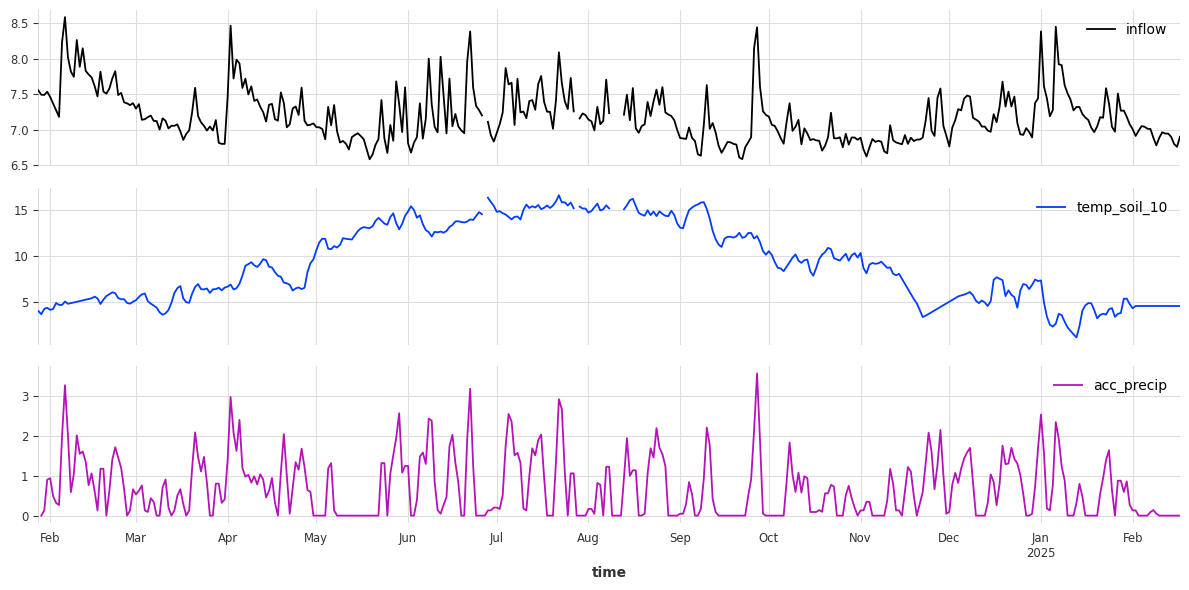

In [113]:
daily_data = (
    data[["inflow", "acc_precip", "temp_soil_10"]]
    .resample("1D", closed="right")
    .agg({"inflow": "mean", "temp_soil_10": "mean", "acc_precip": "sum"})
)
daily_data["inflow"] = daily_data["inflow"].apply(np.log1p)
daily_data["acc_precip"] = daily_data["acc_precip"].apply(np.log1p)
daily_data["acc_precip"] = daily_data["acc_precip"].rolling(2, center=True).mean()
daily_data.plot(subplots=True, figsize=(12, 6))
plt.tight_layout()

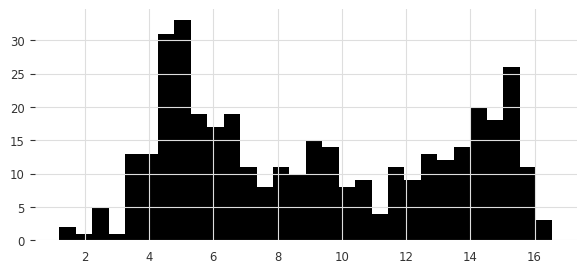

In [134]:
daily_data["temp_soil_10"].hist(bins=30, figsize=(7, 3));

In [ ]:
from sklearn.mixture import GaussianMixture

num_components = 3

daily_temp_soil = daily_data["temp_soil_10"].interpolate().values.reshape(-1, 1)
clust_model = GaussianMixture(n_components=num_components).fit(daily_temp_soil)
daily_data["soil_heat"] = clust_model.predict(daily_temp_soil)

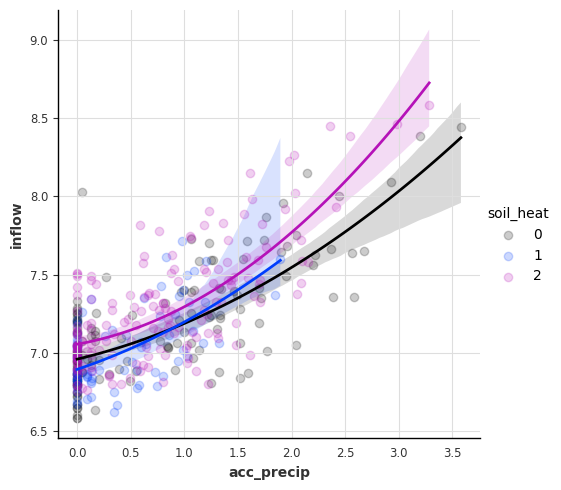

In [ ]:
sns.lmplot(
    daily_data,
    x="acc_precip",
    y="inflow",
    hue="soil_heat",
    order=2,
    scatter_kws=dict(alpha=0.2),
)

In [81]:
ts = TimeSeries.from_dataframe(data, freq="h")
subts = extract_subseries(ts)
subts = [fill_missing_values(s) for s in subts]

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


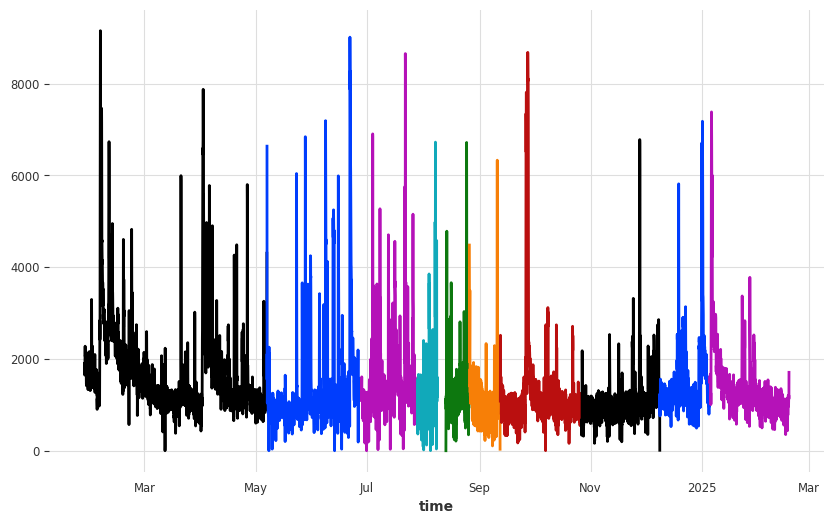

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in subts:
    s["FB20F11_81"].plot(ax=ax)
ax.legend().set_visible(False)